<a href="https://colab.research.google.com/github/briadraper/bd_portfolio/blob/main/salt_lake_air_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INTRODUCTION


---


data source - https://www.kaggle.com/sogun3/uspollution

The EPA collects air quality data across the United States at outdoor monitors. They provide access to this information for any concerned citizen. 

The dataset I used was provided on Kaggle. It was accessed through an API and cleaned. It was offered in a CSV format. 

Each row of the dataset provides the location, sample date, and units, mean, 1st Max Value, 1st Max Hour and AQI for each pollutant. The pollutants being measured are Nitrogen Dioxide (NO2), Sulfur Dioxide (SO2), Ozone (O3) and Carbon Monoxide (CO).

The metric I am analyzing is AQI. This is an index for reporting air quality. It tells how clean or polluted the air is. It ranges from 0-500. An AQI of 0 - 50 represents good air quality with little potential to affect public health. The higher the AQI the worse for people's health.


OBJECTIVE


---


I want to use this data to evaluate the air quality in Salt Lake City compared to cities of similar metropolitan size and population density. Salt Lake City is in a basin surrounded by mountains. It experiences weather inversions that trap pollution resulting in poor air quality. Salt Lake is also experiencing the fastest population growth in the country at 17% from 2010 to 2020.
I want to compare the average AQI for Salt Lake to other comparable cities to see if the topography and weather of Salt Lake are resulting in significantly worse air quality.
The comparison cities were chosen based on their metro population and population density.

*   Salt Lake City, UT
        2010 Metro Population - 1.08 M
        Population Density persons/sq mi - 1,742

*   Oklahoma City, OK
        2010 Metro Population - 1.252 M
        Population Density persons/sq mi - 1,053
        
*   Raleigh, NC
        2010 Metro Population - 1.13 M
        Population Density persons/sq mi - 1,221

*   Birmingham, AL
        2010 Metro Population - 1.06 M
        Population Density persons/sq mi - 1,452

*   Louisville, KY
        2010 Metro Population - 1.2 M
        Population Density persons/sq mi - 2,339

For the comparison group(Oklahoma City, Raleigh, Birmingham and Louisville) the average metro population is 1.16 M and the average population density is 1,517/sq mi.
The time period for accepted sampling is 2011 to 2016.


HYPOTHESIS


---

For each pollutant (NO2, SO2, O3 and CO), 
the null hypothesis states that there is no difference in the mean AQI between Salt Lake City and the comparison group.

H₀: μ₁ - μ₂ = 0 

The alternative hypothesis states that there is a difference in the mean AQI between Salt Lake City and the comparison group.

Hₐ: μ₁ - μ₂ ≠ 0

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd


sns.set_style('white')

import warnings
warnings.filterwarnings("ignore")

#allow full result to display 
pd.options.display.max_seq_items = 500


In [ ]:

path = '/content/gdrive/MyDrive/Colab  Datasets/pollute.csv'
master_pollute_df = pd.read_csv(path)
master_pollute_df.head()

,Unnamed: 0,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Units,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.022500,0.040,10,34,Parts per billion,3.000000,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN
1,1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.022500,0.040,10,34,Parts per billion,3.000000,9.0,21,13.0,Parts per million,0.878947,2.2,23,25.0
2,2,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.022500,0.040,10,34,Parts per billion,2.975000,6.6,23,NaN,Parts per million,1.145833,4.2,21,NaN
3,3,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.022500,0.040,10,34,Parts per billion,2.975000,6.6,23,NaN,Parts per million,0.878947,2.2,23,25.0
4,4,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-02,Parts per billion,22.958333,36.0,19,34,Parts per million,0.013375,0.032,10,27,Parts per billion,1.958333,3.0,22,4.0,Parts per million,0.850000,1.6,23,NaN


DATA EXPLORATION



---

To test my hypthesis, I needed the data sorted.

I first dropped any rows with null values.

I grouped the data into each city of interest and evaluated which years were present in the group. I didn't want any values from before 2011 or after 2016, which were the years I had available for the samples collected in Salt Lake. 

I ran descriptive statistics for each city to get an idea of what the range of AQI was for each pollutant. 

In [ ]:
#drop rows with missing values
clean_master_pollute_df = master_pollute_df.dropna(axis='rows')
clean_master_pollute_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 436876 entries, 1 to 1746658
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         436876 non-null  int64  
 1   State Code         436876 non-null  int64  
 2   County Code        436876 non-null  int64  
 3   Site Num           436876 non-null  int64  
 4   Address            436876 non-null  object 
 5   State              436876 non-null  object 
 6   County             436876 non-null  object 
 7   City               436876 non-null  object 
 8   Date Local         436876 non-null  object 
 9   NO2 Units          436876 non-null  object 
 10  NO2 Mean           436876 non-null  float64
 11  NO2 1st Max Value  436876 non-null  float64
 12  NO2 1st Max Hour   436876 non-null  int64  
 13  NO2 AQI            436876 non-null  int64  
 14  O3 Units           436876 non-null  object 
 15  O3 Mean            436876 non-null  float64
 16  O

In [ ]:
#drop columns 
pollute_df = clean_master_pollute_df.drop(['Unnamed: 0', 'State Code', 'County Code', 'Site Num', 'Address', 'State', 'County', 'NO2 Units', 'NO2 Mean', 'NO2 1st Max Value', 'NO2 1st Max Hour', 'SO2 Units', 'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour', 'O3 Units', 'O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'CO Units', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour'],axis=1)
pollute_df.head()

,City,Date Local,NO2 AQI,O3 AQI,SO2 AQI,CO AQI
1,Phoenix,2000-01-01,46,34,13.0,25.0
5,Phoenix,2000-01-02,34,27,4.0,26.0
9,Phoenix,2000-01-03,48,14,16.0,28.0
13,Phoenix,2000-01-04,72,28,23.0,34.0
17,Phoenix,2000-01-05,58,10,21.0,42.0


In [ ]:
#add year column
pollute_df['year'] = pd.DatetimeIndex(pollute_df['Date Local']).year
pollute_df.head()

,City,Date Local,NO2 AQI,O3 AQI,SO2 AQI,CO AQI,year
1,Phoenix,2000-01-01,46,34,13.0,25.0,2000
5,Phoenix,2000-01-02,34,27,4.0,26.0,2000
9,Phoenix,2000-01-03,48,14,16.0,28.0,2000
13,Phoenix,2000-01-04,72,28,23.0,34.0,2000
17,Phoenix,2000-01-05,58,10,21.0,42.0,2000


In [ ]:
#group by city - salt lake
by_city = pollute_df.groupby('City')
sl_group = by_city.get_group('Salt Lake City')
sl_group.describe()

,NO2 AQI,O3 AQI,SO2 AQI,CO AQI,year
count,1645.000000,1645.000000,1645.000000,1645.000000,1645.000000
mean,29.921581,40.519149,1.477812,5.679027,2012.880243
std,11.044339,21.687908,2.921150,3.706091,1.415376
min,2.000000,0.000000,0.000000,1.000000,2011.000000
25%,22.000000,28.000000,0.000000,3.000000,2012.000000
50%,29.000000,38.000000,1.000000,5.000000,2013.000000
75%,38.000000,47.000000,1.000000,7.000000,2014.000000
max,74.000000,147.000000,64.000000,31.000000,2016.000000


In [ ]:
#show sample ditributions by year taken
sl_year_counts = sl_group['year'].value_counts()
sl_year_counts

2011    361
2012    358
2013    338
2014    314
2015    253
2016     21
Name: year, dtype: int64

In [ ]:
#group by city - birmingham
by_city = pollute_df.groupby('City')
birm_group = by_city.get_group('Birmingham')
birm_group.describe()

,NO2 AQI,O3 AQI,SO2 AQI,CO AQI,year
count,782.00000,782.000000,782.000000,782.000000,782.000000
mean,21.22890,36.831202,7.005115,3.851662,2014.725064
std,9.27003,14.942987,10.721237,2.212985,0.812742
min,1.00000,0.000000,0.000000,1.000000,2013.000000
25%,14.00000,28.000000,1.000000,2.000000,2014.000000
50%,21.50000,35.000000,3.000000,3.000000,2015.000000
75%,28.00000,43.000000,9.000000,6.000000,2015.000000
max,82.00000,147.000000,97.000000,20.000000,2016.000000


In [ ]:
#show sample ditributions by year taken
birm_year_counts = birm_group['year'].value_counts()
birm_year_counts

2014    302
2015    300
2016    149
2013     31
Name: year, dtype: int64

In [ ]:
#group by city - oklahoma city
by_city = pollute_df.groupby('City')
ok_group = by_city.get_group('Oklahoma City')
ok_group.describe()

,NO2 AQI,O3 AQI,SO2 AQI,CO AQI,year
count,1506.000000,1506.000000,1506.000000,1506.000000,1506.000000
mean,13.749668,43.861222,1.004648,2.387118,2012.693227
std,9.129363,20.905959,1.415849,1.876469,1.223326
min,0.000000,5.000000,0.000000,0.000000,2011.000000
25%,7.000000,31.000000,0.000000,1.000000,2012.000000
50%,10.000000,39.000000,1.000000,2.000000,2013.000000
75%,20.000000,48.000000,1.000000,3.000000,2014.000000
max,52.000000,147.000000,10.000000,23.000000,2015.000000


In [ ]:
#show sample ditributions by year taken
ok_year_counts = ok_group['year'].value_counts()
ok_year_counts

2014    363
2013    363
2012    363
2011    324
2015     93
Name: year, dtype: int64

In [ ]:
#group by city - raleigh
by_city = pollute_df.groupby('City')
ral_group = by_city.get_group('Raleigh')
ral_group.describe()

,NO2 AQI,O3 AQI,SO2 AQI,CO AQI,year
count,795.000000,795.000000,795.000000,795.000000,795.000000
mean,13.945912,36.714465,0.781132,4.174843,2014.677987
std,8.855165,12.432902,1.535441,2.349419,0.669189
min,0.000000,6.000000,0.000000,1.000000,2014.000000
25%,7.000000,29.000000,0.000000,3.000000,2014.000000
50%,12.000000,35.000000,0.000000,3.000000,2015.000000
75%,20.000000,44.000000,1.000000,5.000000,2015.000000
max,42.000000,101.000000,13.000000,15.000000,2016.000000


In [ ]:
#show sample ditributions by year taken
ral_year_counts = ral_group['year'].value_counts()
ral_year_counts

2015    357
2014    347
2016     91
Name: year, dtype: int64

In [ ]:
#group by city - louisville
by_city = pollute_df.groupby('City')
lou_group = by_city.get_group('Louisville')
lou_group.describe()

,NO2 AQI,O3 AQI,SO2 AQI,CO AQI,year
count,972.000000,972.000000,972.000000,972.000000,972.000000
mean,23.307613,38.618313,17.870370,5.358025,2006.865226
std,9.628262,21.136051,24.244032,3.636893,6.738254
min,0.000000,3.000000,0.000000,0.000000,2000.000000
25%,17.000000,25.000000,3.000000,3.000000,2001.000000
50%,24.000000,35.000000,7.000000,5.000000,2002.000000
75%,29.000000,45.000000,24.000000,7.000000,2014.000000
max,58.000000,174.000000,137.000000,20.000000,2015.000000


In [ ]:
#show sample ditributions by year taken
lou_year_counts = lou_group['year'].value_counts()
lou_year_counts

2000    223
2015    193
2001    192
2014    163
2002    119
2013     82
Name: year, dtype: int64

In [ ]:
#drop years for louisville group that don't match the sample date range of the other cities 
lou_group = lou_group[lou_group.year > 2009]

In [ ]:
lou_year_counts = lou_group['year'].value_counts()
lou_year_counts

DATA EXPLORATION CONTINUED


---

I grouped together the comparison cities to compare against Salt Lake. 

In [ ]:
#group together the comparison cities to find mean values to compare against salt lake
comp_group_concat = pd.concat([
    lou_group.assign(dataset='lou_group'), 
    birm_group.assign(dataset='birm_group'), 
    ral_group.assign(dataset='ral_group'), 
    ok_group.assign(dataset='ok_group')])

In [ ]:
#check for cities in comp_group
comp_group_cities = comp_group_concat['City'].value_counts()
comp_group_cities

Oklahoma City    1506
Raleigh           795
Birmingham        782
Louisville        438
Name: City, dtype: int64

In [ ]:
comp_group_concat.describe()

,NO2 AQI,O3 AQI,SO2 AQI,CO AQI,year
count,3521.000000,3521.000000,3521.000000,3521.000000,3521.000000
mean,16.385686,39.300483,2.813121,3.368929,2013.786708
std,9.838212,18.191001,6.394890,2.302035,1.367938
min,0.000000,0.000000,0.000000,0.000000,2011.000000
25%,8.000000,28.000000,0.000000,2.000000,2013.000000
50%,14.000000,36.000000,1.000000,3.000000,2014.000000
75%,24.000000,45.000000,3.000000,5.000000,2015.000000
max,82.000000,174.000000,97.000000,23.000000,2016.000000


Text(0.5, 1.0, 'Distribution of NO2 AQI for Salt Lake City and Comp Cities')

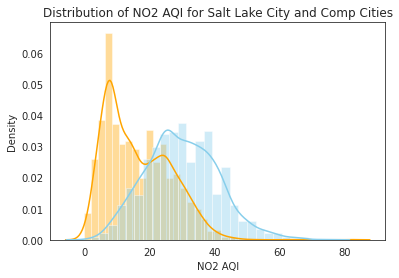

In [ ]:
#plot the distribution of NO2 AQI for the comp group
ax1 = sns.distplot(comp_group_concat['NO2 AQI'], color='orange')

#plot the distribution of NO2 AQI for salt lake city
ax1 = sns.distplot(sl_group['NO2 AQI'], color='skyblue')

ax1.set_title('Distribution of NO2 AQI for Salt Lake City and Comp Cities')

AX1 Interpretation


---


You can see the NO2 AQI for Salt Lake City (skyblue), is sampling higher than the comparison group. The data for both groups follows a normal distribution. 

Text(0.5, 1.0, 'Distribution of O3 AQI for Salt Lake City and Comp Cities')

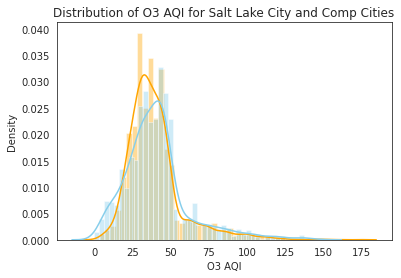

In [ ]:
#plot the distribution of O3 AQI for the comp group
ax2 = sns.distplot(comp_group_concat['O3 AQI'], color='orange')

#plot the distribution of O3 AQI for salt lake city
ax2 = sns.distplot(sl_group['O3 AQI'], color='skyblue')

ax2.set_title('Distribution of O3 AQI for Salt Lake City and Comp Cities')

AX2 Interpretation


---

The O3 AQI for both Salt Lake City and the comparison group are normally distributed.

Text(0.5, 1.0, 'Distribution of SO2 AQI for Salt Lake City and Comp Cities')

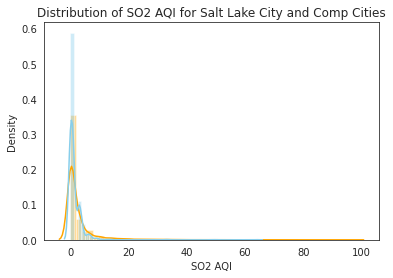

In [ ]:
#plot the distribution of SO2 AQI for the comp group
ax3 = sns.distplot(comp_group_concat['SO2 AQI'], color='orange')

#plot the distribution of SO2 AQI for salt lake
ax3 = sns.distplot(sl_group['SO2 AQI'], color='skyblue')

ax3.set_title('Distribution of SO2 AQI for Salt Lake City and Comp Cities')

AX3 Interpretation


---

The SO2 AQI for both Salt Lake City and the comparison group are normally distributed.

Text(0.5, 1.0, 'Distribution of CO AQI for Salt Lake City and Comp Cities')

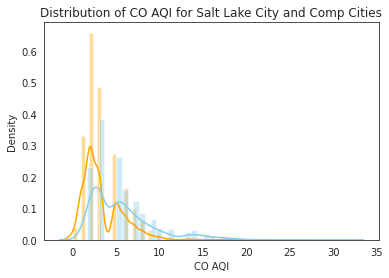

In [ ]:
#plot the distribution of CO AQI for the comp group
ax4 = sns.distplot(comp_group_concat['CO AQI'], color='orange')

#plot the distribution of CO AQI for salt lake city
ax4 = sns.distplot(sl_group['CO AQI'], color='skyblue')

ax4.set_title('Distribution of CO AQI for Salt Lake City and Comp Cities')

AX4 Interpretation


---

The CO AQI for both Salt Lake City and the comparison group are normally distributed.

In [ ]:
#add salt lake to comparison group in order to plot
concatenated_comp_sl = pd.concat([sl_group.assign(dataset='sl_group'), comp_group_concat.assign(dataset='comp_group_concat')])

Text(0.5, 1.0, 'Mean NO2 AQI')

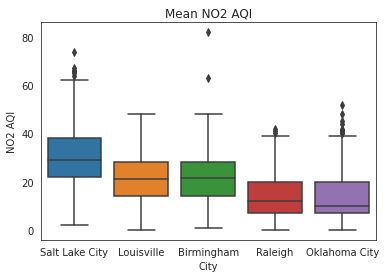

In [ ]:
ax5 = sns.boxplot(y='NO2 AQI', x='City', data=concatenated_comp_sl)

ax5.set_title('Mean NO2 AQI')

AX5 Interpretation


---

Box plots representing the mean NO2 AQI for Salt Lake City compared to the four comparison cities. The mean NO2 for Salt Lake is higher than the comp cities.



Text(0.5, 1.0, 'Mean O3 AQI')

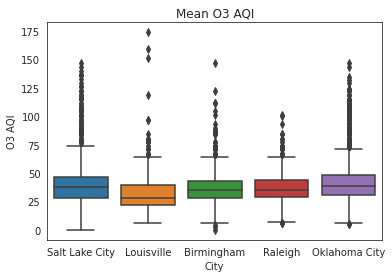

In [ ]:
ax6 = sns.boxplot(y='O3 AQI', x='City', data=concatenated_comp_sl)

ax6.set_title('Mean O3 AQI')

AX6 Interpretation
Box plots representing the mean O3 AQI for Salt Lake City compared to the four comparison cities. The mean NO2 for Salt Lake is only slightly higher than the comp cities.

Text(0.5, 1.0, 'Mean SO2 AQI')

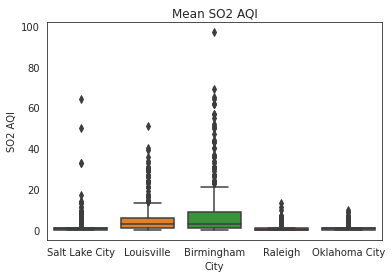

In [ ]:
ax7 = sns.boxplot(y='SO2 AQI', x='City', data=concatenated_comp_sl)

ax7.set_title('Mean SO2 AQI')

AX7 INTERPRETATION


---

The mean SO2 Aqi for Lousiville and Birmingham is nudging the average higher for the comp group than for Salt Lake. 

Text(0.5, 1.0, 'Mean CO AQI')

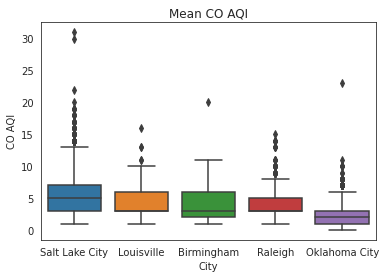

In [ ]:
ax8 = sns.boxplot(y='CO AQI', x='City', data=concatenated_comp_sl)

ax8.set_title('Mean CO AQI')

AX8 Interpretation
Box plots representing the mean CO AQI for Salt Lake City compared to the four comparison cities. The mean CO for Salt Lake is higher than the comp cities.

HYPOTHESIS TESTING


---

To test my hypothesis, I wanted to list out the mean AQI's for the comparison group and Salt Lake City.

I then ran a tTest for each pollutant mean AQI value for Salt Lake City and the comparison group.

I calculated the confidence intervals for each tTest and interpreted the results.

In [ ]:
def series_statistics_comp_NO2(column):
    print('The mean value of the NO2 AQI column: {} for the comp group'.format(column.mean()))
def series_statistics_comp_SO2(column):
    print('The mean value of the SO2 AQI column: {} for the comp group'.format(column.mean()))
def series_statistics_comp_O3(column):
    print('The mean value of the O3 AQI column: {} for the comp group'.format(column.mean()))
def series_statistics_comp_CO(column):
    print('The mean value of the CO AQI column: {} for the comp group'.format(column.mean()))
def series_statistics_sl_NO2(column):
    print('The mean value of the NO2 AQI column: {} for the Salt Lake group'.format(column.mean()))
def series_statistics_sl_SO2(column):
    print('The mean value of the SO2 AQI column: {} for the Salt Lake group'.format(column.mean()))
def series_statistics_sl_O3(column):
    print('The mean value of the O3 AQI column: {} for the Salt Lake group'.format(column.mean()))
def series_statistics_sl_CO(column):
    print('The mean value of the CO AQI column: {} for the Salt Lake group'.format(column.mean()))

In [ ]:
#list the mean values for the salt lake group
print("Mean values for the AQI's of the Salt Lake group:")
series_statistics_sl_NO2(sl_group['NO2 AQI'])
series_statistics_sl_SO2(sl_group['SO2 AQI'])
series_statistics_sl_O3(sl_group['O3 AQI'])
series_statistics_sl_CO(sl_group['CO AQI'])

Mean values for the AQI's of the Salt Lake group:
The mean value of the NO2 AQI column: 29.921580547112463 for the Salt Lake group
The mean value of the SO2 AQI column: 1.4778115501519757 for the Salt Lake group
The mean value of the O3 AQI column: 40.51914893617021 for the Salt Lake group
The mean value of the CO AQI column: 5.6790273556231 for the Salt Lake group


In [ ]:
#list the mean values for the comp group
print("Mean values for the AQI's of the comp group:")
series_statistics_comp_NO2(comp_group_concat['NO2 AQI'])
series_statistics_comp_SO2(comp_group_concat['SO2 AQI'])
series_statistics_comp_O3(comp_group_concat['O3 AQI'])
series_statistics_comp_CO(comp_group_concat['CO AQI'])

Mean values for the AQI's of the comp group:
The mean value of the NO2 AQI column: 16.38568588469185 for the comp group
The mean value of the SO2 AQI column: 2.8131212723658052 for the comp group
The mean value of the O3 AQI column: 39.30048281738143 for the comp group
The mean value of the CO AQI column: 3.3689292814541325 for the comp group


The mean AQI's for Salt Lake City are higher than the comparison group for NO2, O3 and CO.
The mean SO2 AQI for Salt Lake City is lower than the comparison group. 




In [ ]:
#ttest for salt lake vs comp group for NO2
stats.ttest_ind(sl_group['NO2 AQI'], comp_group_concat['NO2 AQI'])

Ttest_indResult(statistic=44.27174722732451, pvalue=0.0)

In [ ]:
#ttest for salt lake vs comp group for SO2
stats.ttest_ind(sl_group['SO2 AQI'], comp_group_concat['SO2 AQI'])

Ttest_indResult(statistic=-8.083813920895958, pvalue=7.753772646730877e-16)

In [ ]:
#ttest for salt lake vs comp group for O3
stats.ttest_ind(sl_group['O3 AQI'], comp_group_concat['O3 AQI'])

Ttest_indResult(statistic=2.106344193034903, pvalue=0.03522259416160483)

In [ ]:
#ttest for salt lake vs comp group for O3
stats.ttest_ind(sl_group['CO AQI'], comp_group_concat['CO AQI'])

Ttest_indResult(statistic=27.373671508790558, pvalue=3.59466837841497e-154)

All the AQI Ttest's resulted in a p-value < 0.05 and therefore we can reject the Null hypothesis that there is no difference in the mean AQI between Salt Lake City and the comparison group.

In [ ]:
# calculate the sample size, mean, and variance then calculate standard errors and compute the confidence intervals

import math 

def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    print("The difference in mean values for Salt Lake City and the comp group at the 95% confidence interval is between "+str(ci_lower)+" and "+str(ci_upper)+".")

In [ ]:
# run confidence interval function for NO2 AQI
print('NO2 AQI: ')
get_95_ci(sl_group['NO2 AQI'],comp_group_concat['NO2 AQI'])


NO2 AQI: 
The difference in mean values for Salt Lake City and the comp group at the 95% confidence interval is between -14.160762443421643 and -12.911026881419584.


In [ ]:
# run confidence interval function for SO2 AQI
print('SO2 AQI: ')
get_95_ci(sl_group['SO2 AQI'],comp_group_concat['SO2 AQI'])

SO2 AQI: 
The difference in mean values for Salt Lake City and the comp group at the 95% confidence interval is between 1.0812511419227695 and 1.5893683025048895.


In [ ]:
# run confidence interval function for NO2 AQI
print('O3 AQI: ')
get_95_ci(sl_group['O3 AQI'],comp_group_concat['O3 AQI'])

O3 AQI: 
The difference in mean values for Salt Lake City and the comp group at the 95% confidence interval is between -2.4267623702926224 and -0.010569867284942136.


In [ ]:
# run confidence interval function for NO2 AQI
print('CO AQI: ')
get_95_ci(sl_group['CO AQI'],comp_group_concat['CO AQI'])

CO AQI: 
The difference in mean values for Salt Lake City and the comp group at the 95% confidence interval is between -2.5046687909012855 and -2.11552735743665.


STATISTICAL ANALYSIS


---



NO2 -
Reject the null that there is no difference between Salt Lake City and the comparison group for average NO2.
The difference is signifcant at p = 0.0. 
The 95% confidence interval for the population difference is 12.91 and 14.16, with Salt Lake having the higher NO2.

SO2 -
Reject the null that there is no difference between Salt Lake City and the comparison group for average SO2.
The difference is signifcant at p = 7.753772646730877e-16. 
The 95% confidence interval for the population difference is 1.08 and 1.59.
The mean SO2 AQI for Salt Lake City is 1.48 vs 2.8 for the comp group. The average SO2 is higher for the comparison group than Salt Lake City.

O3 -
Reject the null that there is no difference between Salt Lake City and the comparison group for average O3.
The difference is signifcant at p = 0.03522259416160483. 
The 95% confidence interval for the population difference is 0.01 and 2.43.
The mean O3 AQI for Salt Lake City is 40.5 vs 39.3 for the comp group. Using the confidence interval, the difference is between 0.01 and 2.4 AQI.

CO -
Reject the null that there is no difference between Salt Lake City and the comparison group for average CO.
The difference is signifcant at p = 3.59466837841497e-154.
The mean CO AQI for Salt Lake City is 5.7 vs 3.37 for the comp group. Using the confidence interval, the difference is likely between 2.1 and 2.5 AQI.

CONCLUSION


---

The air quality in Salt Lake City is worse than cities of comparable metro populations and population density. 

City officials should take steps to reduce air pollution from vehicles and industry to prevent air quality from worsening as the population continues to increase.

FURTHER CONSIDERATIONS


---


Upon further research, there are two coal power plants near Birmingham, AL that would account for the higher SO2 levels in that city. Taking this into consideration we can conclude that Salt Lake City has worse air quality over all than cities of comparable metro population size and density. 

Further, analysis could be done on AQI throughout the seasons and highlighting which sample locations are contributing the most to overall pollution to pinpoint sources.

Confidence Intervals


---

The following code is to find the variance and sample size of each component. I then visualized confidence intervals in Excel.

In [ ]:
sl_var = sl_group['NO2 AQI'].var()
sl_shape = sl_group['NO2 AQI'].shape[0]
sl_var
sl_shape

1645

In [ ]:
sl_var

121.97742329110545

In [ ]:
cg_var = comp_group_concat['NO2 AQI'].var()
cg_shape = comp_group_concat['NO2 AQI'].shape[0]

In [ ]:
cg_var

96.79040868425723

In [ ]:
cg_shape

3521

In [ ]:
#math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
std_error_sl = math.sqrt((sl_var/sl_shape)+(cg_var/cg_shape))
std_error_sl

0.31881009234746416

In [ ]:
sl_var = sl_group['SO2 AQI'].var()
sl_shape = sl_group['SO2 AQI'].shape[0]

In [ ]:
sl_var

8.533114429185387

In [ ]:
sl_shape

1645

In [ ]:
cg_var = comp_group_concat['SO2 AQI'].var()
cg_shape = comp_group_concat['SO2 AQI'].shape[0]

In [ ]:
cg_var

40.89461187420434

In [ ]:
cg_shape

3521

In [ ]:
sl_var = sl_group['O3 AQI'].var()
sl_shape = sl_group['O3 AQI'].shape[0]

In [ ]:
sl_var

470.36535693948485

In [ ]:
cg_var = comp_group_concat['O3 AQI'].var()
cg_shape = comp_group_concat['O3 AQI'].shape[0]

In [ ]:
cg_var

330.9125253350019

In [ ]:
cg_shape

3521

In [ ]:
sl_var = sl_group['CO AQI'].var()
sl_shape = sl_group['CO AQI'].shape[0]

In [ ]:
sl_var

13.735113408618552

In [ ]:
cg_var = comp_group_concat['CO AQI'].var()
cg_shape = comp_group_concat['CO AQI'].shape[0]

In [ ]:
cg_var

5.299363881645008